<a href="https://colab.research.google.com/github/vienskaz/ECG-CNN/blob/main/leakyEKG_GANtwoldim50_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras import layers, models
import seaborn as sns
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense


In [2]:
mit_test_data = pd.read_csv('/content/drive/MyDrive/ecg/mitbih_test.csv', header=None)
mit_train_data = pd.read_csv('/content/drive/MyDrive/ecg/mitbih_train.csv', header=None)

X_train = mit_train_data.iloc[:, :-1].values
y_train = mit_train_data.iloc[:, -1].values
X_test = mit_test_data.iloc[:, :-1].values
y_test = mit_test_data.iloc[:, -1].values

normal = pd.read_csv('/content/drive/MyDrive/ecg/ptbdb_normal.csv', header=None)
abnormal = pd.read_csv('/content/drive/MyDrive/ecg/ptbdb_abnormal.csv', header=None)
X_normal = normal.iloc[:, :-1].values
y_normal = np.zeros(X_normal.shape[0])
X_abnormal = abnormal.iloc[:, :-1].values
y_abnormal = np.ones(X_abnormal.shape[0])

X = np.concatenate([X_normal, X_abnormal], axis=0)
y = np.concatenate([y_normal, y_abnormal], axis=0)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
X = X.reshape((X.shape[0], X.shape[1], 1))

Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)

In [3]:
def moving_average_filter(signal, window_size=5):
    filtered=[]
    for data in signal:
      filtered_ecg = np.convolve(data.flatten(), np.ones(window_size) / window_size, mode='same')
      filtered.append(filtered_ecg)
    return np.array(filtered)


In [4]:
two = []
three = []
four = []
five = []

for i in range(len(Y_train)):
    if np.array_equal(Y_train[i], [0.0, 1.0, 0.0, 0.0, 0.0]):
        two.append(X_train[i])
    elif np.array_equal(Y_train[i], [0.0, 0.0, 1.0, 0.0, 0.0]):
        three.append(X_train[i])
    elif np.array_equal(Y_train[i], [0.0, 0.0, 0.0, 1.0, 0.0]):
        four.append(X_train[i])
    elif np.array_equal(Y_train[i], [0.0, 0.0, 0.0, 0.0, 1.0]):
        five.append(X_train[i])




In [5]:
np.array(two)
np.array(three)
np.array(four )
np.array(five )

array([[[0.71260995],
        [0.62903225],
        [0.52785921],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[1.        ],
        [0.4848485 ],
        [0.54166669],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.58404559],
        [0.5       ],
        [0.42450142],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       ...,

       [[0.90612245],
        [0.62448978],
        [0.59591836],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.85822785],
        [0.64556962],
        [0.84556961],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.90150636],
        [0.84588647],
        [0.80069524],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]]])

In [ ]:
print(len(two))
print(len(three))
print(len(four))
print(len(five))

2223
5788
641
6431


In [5]:
two = moving_average_filter(two)
three = moving_average_filter(three)
four = moving_average_filter(four)
five = moving_average_filter(five)

In [ ]:
print(two[0].shape)

(187,)


In [6]:
def build_discriminator(n=187):
    inps = layers.Input(shape=(n,))
    x = Dense(512,  activation=keras.layers.LeakyReLU(alpha=0.02))(inps)
    x = Dense(512, activation=keras.layers.LeakyReLU(alpha=0.02))(x)
    x = Dense(256, activation=keras.layers.LeakyReLU(alpha=0.02))(x)
    outs = Dense(1, activation='sigmoid')(x)
    model = models.Model(inps, outs, name='discriminator')
    return model



def build_generator(latent_dim=50, output_shape=(187, 1)):
    inps = layers.Input(shape=(latent_dim,))
    x = Dense(256, activation=keras.layers.LeakyReLU(alpha=0.02))(inps)
    x = Dense(256, activation=keras.layers.LeakyReLU(alpha=0.02))(x)
    outs = Dense(187, activation='tanh')(x)
    model = models.Model(inps, outs, name='generator')
    return model



discriminator = build_discriminator()
generator = build_generator(latent_dim=50)
print(discriminator.summary())
print(generator.summary())

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 187)]             0         
                                                                 
 dense (Dense)               (None, 512)               96256     
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 490497 (1.87 MB)
Trainable params: 490497 (1.87 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Model: "gene

In [7]:
class GAN(keras.Model):

    def __init__(self, disc, gen, latent_dim=50):
        super(GAN, self).__init__()
        self.discriminator = disc
        self.generator = gen
        self.latent_dim = latent_dim

    def compile(self, optD, optG, loss_fn):
        super(GAN, self).compile()
        self.optD = optD
        self.optG = optG
        self.loss_fn = loss_fn

    def train_step(self, real_data):
        if isinstance(real_data, tuple):
            real_data = real_data[0]

        bs = tf.shape(real_data)[0]
        z = tf.random.normal(shape=(bs, self.latent_dim))
        fake_data = self.generator(z)

        combined_data = tf.concat([real_data, fake_data], axis=0)
        labels = tf.concat([tf.ones((bs, 1)), tf.zeros((bs, 1))], axis=0)

        with tf.GradientTape() as tape:
            preds = self.discriminator(combined_data)
            d_loss = self.loss_fn(labels, preds)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.optD.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        misleading_labels = tf.ones((bs, 1))
        z = tf.random.normal(shape=(bs, self.latent_dim))

        with tf.GradientTape() as tape:
            fake_preds = self.discriminator(self.generator(z))
            g_loss = self.loss_fn(misleading_labels, fake_preds)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.optG.apply_gradients(zip(grads, self.generator.trainable_weights))

        return {"d_loss": d_loss, "g_loss": g_loss}

gan = GAN(discriminator, generator)

gan.compile(
    optD=keras.optimizers.Adam(learning_rate=0.0001),
    optG=keras.optimizers.Adam(learning_rate=0.001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)


In [9]:
generated_points_list=[]
def show_samples(epoch, generator, data, n=187, l_dim=50):
  if epoch % 300 == 0:
    z = tf.random.normal(shape=(n, l_dim))
    generated_data = generator(z)
    generated_points_list.append(generated_data)
    plt.plot(generated_data)
    plt.show()


Epoch 1/2800
68/70 [============================>.] - ETA: 0s - d_loss: 0.4902 - g_loss: 1.2839

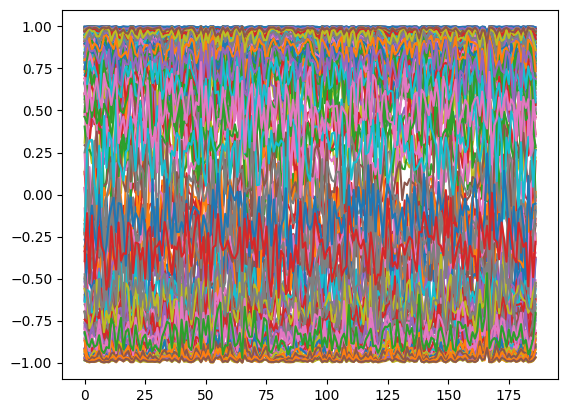

70/70 [==============================] - 7s 26ms/step - d_loss: 0.4877 - g_loss: 1.2929
Epoch 2/2800
70/70 [==============================] - 1s 18ms/step - d_loss: 0.2694 - g_loss: 2.8185
Epoch 3/2800
70/70 [==============================] - 1s 17ms/step - d_loss: 0.1576 - g_loss: 4.1373
Epoch 4/2800
70/70 [==============================] - 1s 17ms/step - d_loss: 0.4046 - g_loss: 3.3749
Epoch 5/2800
70/70 [==============================] - 1s 18ms/step - d_loss: 0.6664 - g_loss: 0.9228
Epoch 6/2800
70/70 [==============================] - 1s 17ms/step - d_loss: 0.6454 - g_loss: 0.8956
Epoch 7/2800
70/70 [==============================] - 1s 17ms/step - d_loss: 0.6141 - g_loss: 1.0875
Epoch 8/2800
70/70 [==============================] - 1s 20ms/step - d_loss: 0.6007 - g_loss: 1.7986
Epoch 9/2800
70/70 [==============================] - 2s 23ms/step - d_loss: 0.7766 - g_loss: 0.9590
Epoch 10/2800
70/70 [==============================] - 2s 23ms/step - d_loss: 0.6927 - g_loss: 0.8899
Ep

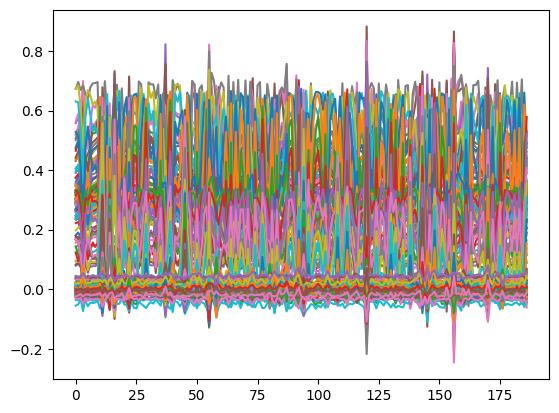

70/70 [==============================] - 2s 32ms/step - d_loss: 0.3774 - g_loss: 1.4253
Epoch 302/2800
70/70 [==============================] - 2s 24ms/step - d_loss: 0.3659 - g_loss: 1.5098
Epoch 303/2800
70/70 [==============================] - 2s 25ms/step - d_loss: 0.3793 - g_loss: 1.4667
Epoch 304/2800
70/70 [==============================] - 2s 25ms/step - d_loss: 0.3739 - g_loss: 1.4735
Epoch 305/2800
70/70 [==============================] - 2s 23ms/step - d_loss: 0.3738 - g_loss: 1.4099
Epoch 306/2800
70/70 [==============================] - 2s 25ms/step - d_loss: 0.3766 - g_loss: 1.5196
Epoch 307/2800
70/70 [==============================] - 2s 23ms/step - d_loss: 0.3553 - g_loss: 1.5025
Epoch 308/2800
70/70 [==============================] - 1s 18ms/step - d_loss: 0.3681 - g_loss: 1.4797
Epoch 309/2800
70/70 [==============================] - 1s 19ms/step - d_loss: 0.3561 - g_loss: 1.5023
Epoch 310/2800
70/70 [==============================] - 1s 18ms/step - d_loss: 0.3792 - 

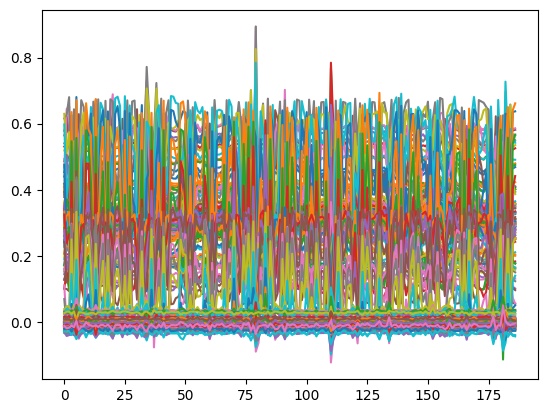

70/70 [==============================] - 2s 31ms/step - d_loss: 0.3615 - g_loss: 1.4938
Epoch 602/2800
70/70 [==============================] - 2s 26ms/step - d_loss: 0.3522 - g_loss: 1.4857
Epoch 603/2800
70/70 [==============================] - 2s 24ms/step - d_loss: 0.3467 - g_loss: 1.7509
Epoch 604/2800
70/70 [==============================] - 2s 25ms/step - d_loss: 0.3653 - g_loss: 1.5218
Epoch 605/2800
70/70 [==============================] - 2s 24ms/step - d_loss: 0.3639 - g_loss: 1.4554
Epoch 606/2800
70/70 [==============================] - 2s 23ms/step - d_loss: 0.3477 - g_loss: 1.4645
Epoch 607/2800
70/70 [==============================] - 2s 24ms/step - d_loss: 0.3558 - g_loss: 1.5968
Epoch 608/2800
70/70 [==============================] - 1s 19ms/step - d_loss: 0.3687 - g_loss: 1.4610
Epoch 609/2800
70/70 [==============================] - 1s 19ms/step - d_loss: 0.3590 - g_loss: 1.4348
Epoch 610/2800
70/70 [==============================] - 1s 19ms/step - d_loss: 0.3532 - 

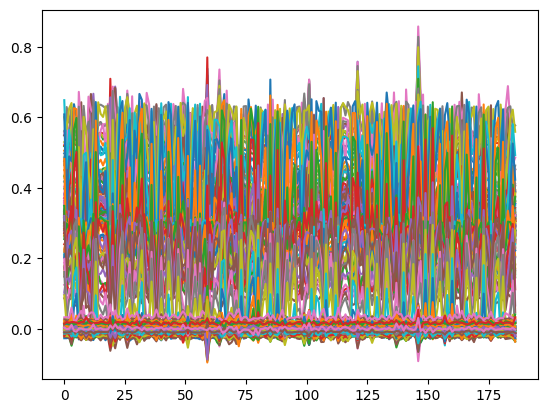

70/70 [==============================] - 2s 29ms/step - d_loss: 0.3402 - g_loss: 1.5003
Epoch 902/2800
70/70 [==============================] - 1s 20ms/step - d_loss: 0.3588 - g_loss: 1.5461
Epoch 903/2800
70/70 [==============================] - 1s 20ms/step - d_loss: 0.3616 - g_loss: 1.5183
Epoch 904/2800
70/70 [==============================] - 1s 19ms/step - d_loss: 0.3595 - g_loss: 1.4853
Epoch 905/2800
70/70 [==============================] - 2s 23ms/step - d_loss: 0.3685 - g_loss: 1.4668
Epoch 906/2800
70/70 [==============================] - 2s 24ms/step - d_loss: 0.3605 - g_loss: 1.4631
Epoch 907/2800
70/70 [==============================] - 2s 26ms/step - d_loss: 0.3498 - g_loss: 1.5319
Epoch 908/2800
70/70 [==============================] - 2s 26ms/step - d_loss: 0.3401 - g_loss: 1.4691
Epoch 909/2800
70/70 [==============================] - 2s 27ms/step - d_loss: 0.3284 - g_loss: 1.6145
Epoch 910/2800
70/70 [==============================] - 2s 24ms/step - d_loss: 0.3497 - 

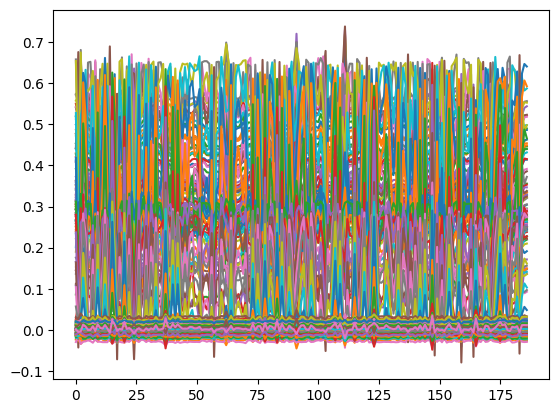

70/70 [==============================] - 3s 42ms/step - d_loss: 0.3371 - g_loss: 1.6034
Epoch 1202/2800
70/70 [==============================] - 2s 26ms/step - d_loss: 0.3498 - g_loss: 1.5596
Epoch 1203/2800
70/70 [==============================] - 2s 25ms/step - d_loss: 0.3211 - g_loss: 1.4837
Epoch 1204/2800
70/70 [==============================] - 1s 21ms/step - d_loss: 0.3661 - g_loss: 1.7992
Epoch 1205/2800
70/70 [==============================] - 2s 22ms/step - d_loss: 0.3453 - g_loss: 1.4418
Epoch 1206/2800
70/70 [==============================] - 2s 22ms/step - d_loss: 0.3461 - g_loss: 1.4185
Epoch 1207/2800
70/70 [==============================] - 2s 22ms/step - d_loss: 0.3464 - g_loss: 1.5576
Epoch 1208/2800
70/70 [==============================] - 1s 21ms/step - d_loss: 0.3439 - g_loss: 1.5094
Epoch 1209/2800
70/70 [==============================] - 1s 21ms/step - d_loss: 0.3345 - g_loss: 1.5395
Epoch 1210/2800
70/70 [==============================] - 2s 31ms/step - d_loss: 

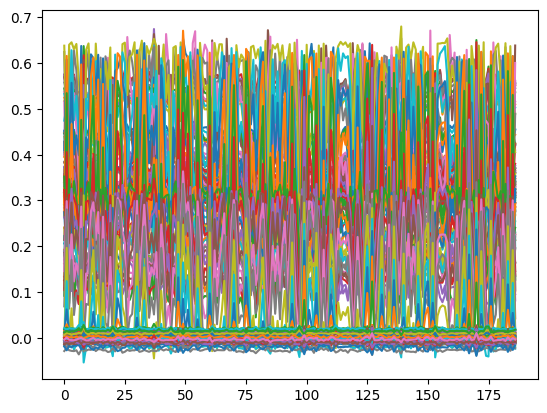

70/70 [==============================] - 3s 42ms/step - d_loss: 0.3518 - g_loss: 1.4908
Epoch 1502/2800
70/70 [==============================] - 2s 28ms/step - d_loss: 0.3449 - g_loss: 1.4245
Epoch 1503/2800
70/70 [==============================] - 2s 27ms/step - d_loss: 0.3438 - g_loss: 1.5864
Epoch 1504/2800
70/70 [==============================] - 2s 25ms/step - d_loss: 0.3126 - g_loss: 1.5332
Epoch 1505/2800
70/70 [==============================] - 2s 23ms/step - d_loss: 0.3550 - g_loss: 1.6726
Epoch 1506/2800
70/70 [==============================] - 1s 21ms/step - d_loss: 0.3403 - g_loss: 1.6782
Epoch 1507/2800
70/70 [==============================] - 1s 21ms/step - d_loss: 0.3283 - g_loss: 1.5392
Epoch 1508/2800
70/70 [==============================] - 1s 21ms/step - d_loss: 0.3281 - g_loss: 1.5725
Epoch 1509/2800
70/70 [==============================] - 1s 21ms/step - d_loss: 0.3334 - g_loss: 1.5941
Epoch 1510/2800
70/70 [==============================] - 2s 22ms/step - d_loss: 

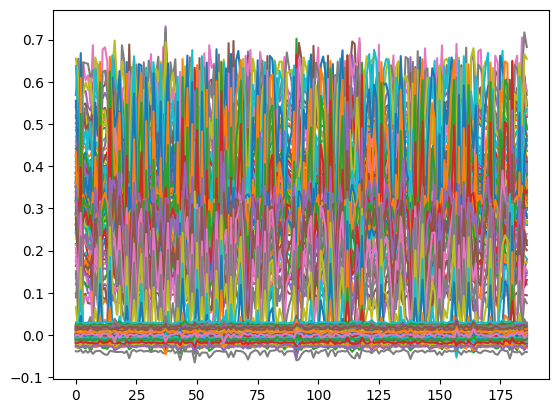

70/70 [==============================] - 3s 45ms/step - d_loss: 0.3187 - g_loss: 1.8144
Epoch 1802/2800
70/70 [==============================] - 2s 23ms/step - d_loss: 0.3408 - g_loss: 1.5177
Epoch 1803/2800
70/70 [==============================] - 2s 24ms/step - d_loss: 0.3362 - g_loss: 1.5651
Epoch 1804/2800
70/70 [==============================] - 2s 24ms/step - d_loss: 0.3088 - g_loss: 1.5074
Epoch 1805/2800
70/70 [==============================] - 2s 24ms/step - d_loss: 0.3533 - g_loss: 1.6906
Epoch 1806/2800
70/70 [==============================] - 2s 24ms/step - d_loss: 0.3363 - g_loss: 1.5269
Epoch 1807/2800
70/70 [==============================] - 2s 23ms/step - d_loss: 0.3349 - g_loss: 1.6346
Epoch 1808/2800
70/70 [==============================] - 2s 24ms/step - d_loss: 0.3291 - g_loss: 1.5150
Epoch 1809/2800
70/70 [==============================] - 2s 22ms/step - d_loss: 0.2905 - g_loss: 1.6834
Epoch 1810/2800
70/70 [==============================] - 2s 25ms/step - d_loss: 

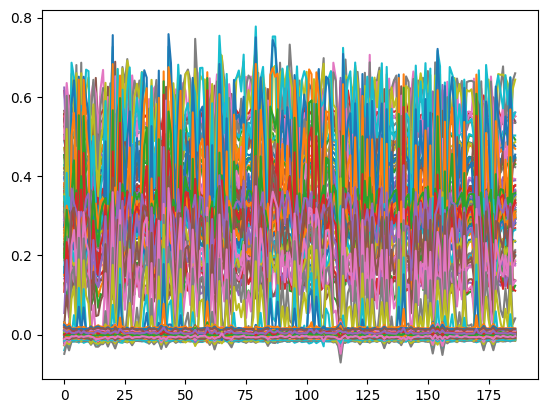

70/70 [==============================] - 3s 40ms/step - d_loss: 0.2987 - g_loss: 1.6986
Epoch 2102/2800
70/70 [==============================] - 2s 29ms/step - d_loss: 0.3134 - g_loss: 1.8030
Epoch 2103/2800
70/70 [==============================] - 2s 29ms/step - d_loss: 0.3062 - g_loss: 1.7202
Epoch 2104/2800
70/70 [==============================] - 2s 29ms/step - d_loss: 0.2986 - g_loss: 1.9071
Epoch 2105/2800
70/70 [==============================] - 2s 29ms/step - d_loss: 0.3152 - g_loss: 1.6121
Epoch 2106/2800
70/70 [==============================] - 2s 28ms/step - d_loss: 0.3046 - g_loss: 2.0874
Epoch 2107/2800
70/70 [==============================] - 2s 28ms/step - d_loss: 0.3389 - g_loss: 1.6236
Epoch 2108/2800
70/70 [==============================] - 2s 23ms/step - d_loss: 0.2645 - g_loss: 1.8293
Epoch 2109/2800
70/70 [==============================] - 2s 23ms/step - d_loss: 0.3010 - g_loss: 1.7492
Epoch 2110/2800
70/70 [==============================] - 2s 24ms/step - d_loss: 

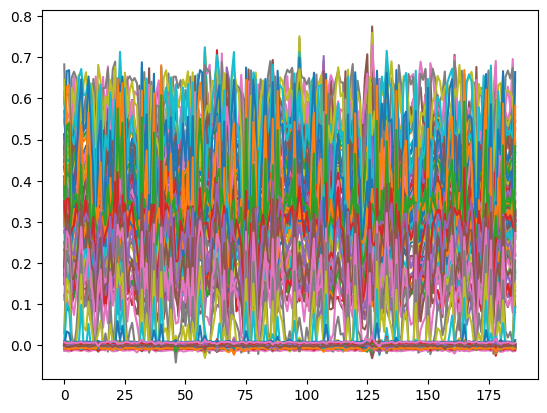

70/70 [==============================] - 3s 43ms/step - d_loss: 0.1915 - g_loss: 3.1504
Epoch 2402/2800
70/70 [==============================] - 2s 25ms/step - d_loss: 0.1899 - g_loss: 3.1164
Epoch 2403/2800
70/70 [==============================] - 2s 31ms/step - d_loss: 0.2314 - g_loss: 2.6436
Epoch 2404/2800
70/70 [==============================] - 2s 28ms/step - d_loss: 0.2336 - g_loss: 2.7406
Epoch 2405/2800
70/70 [==============================] - 2s 29ms/step - d_loss: 0.2222 - g_loss: 2.8822
Epoch 2406/2800
70/70 [==============================] - 2s 30ms/step - d_loss: 0.2265 - g_loss: 2.6785
Epoch 2407/2800
70/70 [==============================] - 2s 25ms/step - d_loss: 0.2061 - g_loss: 2.8992
Epoch 2408/2800
70/70 [==============================] - 2s 26ms/step - d_loss: 0.1741 - g_loss: 2.9855
Epoch 2409/2800
70/70 [==============================] - 2s 24ms/step - d_loss: 0.2155 - g_loss: 2.8412
Epoch 2410/2800
70/70 [==============================] - 2s 23ms/step - d_loss: 

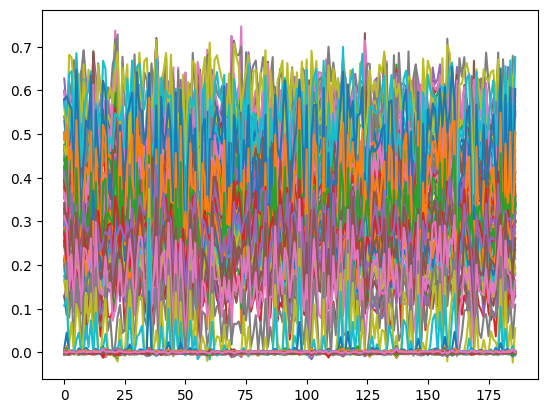

70/70 [==============================] - 3s 43ms/step - d_loss: 0.1595 - g_loss: 3.6866
Epoch 2702/2800
70/70 [==============================] - 2s 24ms/step - d_loss: 0.1560 - g_loss: 3.8220
Epoch 2703/2800
70/70 [==============================] - 2s 26ms/step - d_loss: 0.1545 - g_loss: 3.4162
Epoch 2704/2800
70/70 [==============================] - 2s 28ms/step - d_loss: 0.1572 - g_loss: 3.7677
Epoch 2705/2800
70/70 [==============================] - 2s 26ms/step - d_loss: 0.1622 - g_loss: 4.2196
Epoch 2706/2800
70/70 [==============================] - 2s 24ms/step - d_loss: 0.1658 - g_loss: 3.4833
Epoch 2707/2800
70/70 [==============================] - 2s 24ms/step - d_loss: 0.1745 - g_loss: 3.9294
Epoch 2708/2800
70/70 [==============================] - 2s 24ms/step - d_loss: 0.1528 - g_loss: 3.7515
Epoch 2709/2800
70/70 [==============================] - 2s 24ms/step - d_loss: 0.1521 - g_loss: 4.4432
Epoch 2710/2800
70/70 [==============================] - 2s 24ms/step - d_loss: 

In [ ]:
cbk = keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch,logs: show_samples(epoch, gan.generator, two))
%time hist = gan.fit(two, epochs=2800, callbacks=[cbk], verbose=True)
gan.save_weights('/content/drive/MyDrive/ecg/architektura3/two2800epokleakyrelu')


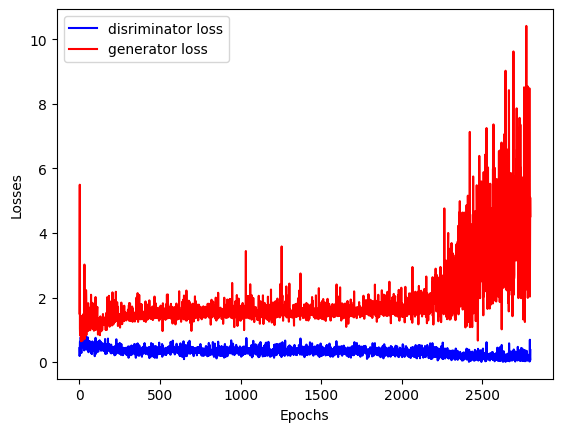

In [ ]:
plt.plot(hist.history['d_loss'], color='blue', label='disriminator loss')
plt.plot(hist.history['g_loss'], color='red', label='generator loss')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.legend()

WAGI DLA 2

In [8]:
gan.load_weights('/content/drive/MyDrive/ecg/architektura3/two2800epokleakyrelu')

In [9]:
def do_data(nums):
    result = []
    latent_dim = 50
    num_samples_to_generate = 1

    for i in range(nums):
        # Generate new set of noise for each iteration
        latent_points = tf.random.normal(shape=(num_samples_to_generate, latent_dim))

        # Use the trained generator to generate data
        generated_data = generator(latent_points)

        # Squeeze the batch dimension, leaving (187, 1)
        generated_data = tf.squeeze(generated_data, axis=0)

        # Convert the TensorFlow tensor to a NumPy array
        generated_data_np = generated_data.numpy()

        # Add the generated data to the result list
        result.append(generated_data_np)

    # Convert the list to a NumPy array
    return np.array(result)

In [ ]:
print(len(two))
print(5000-len(two))

2223
2777


In [40]:
twos=do_data(5)


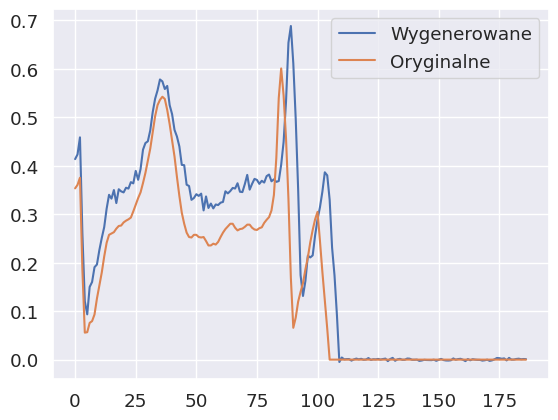

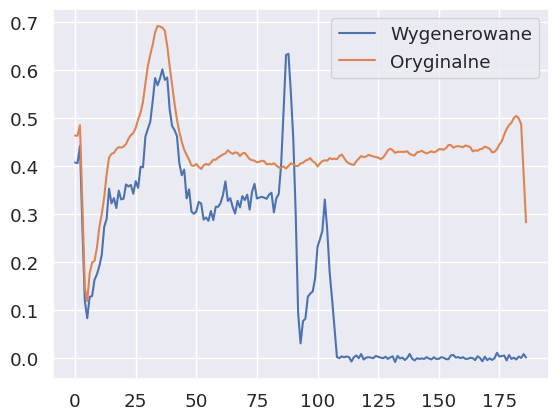

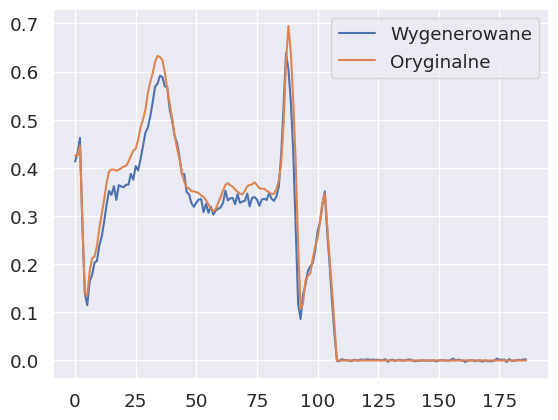

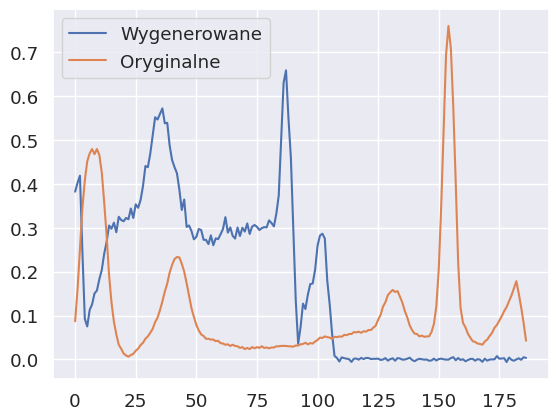

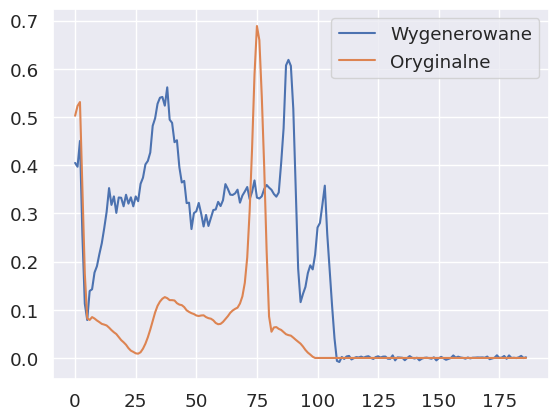

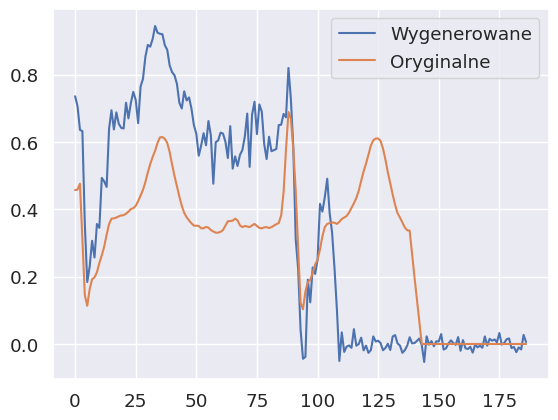

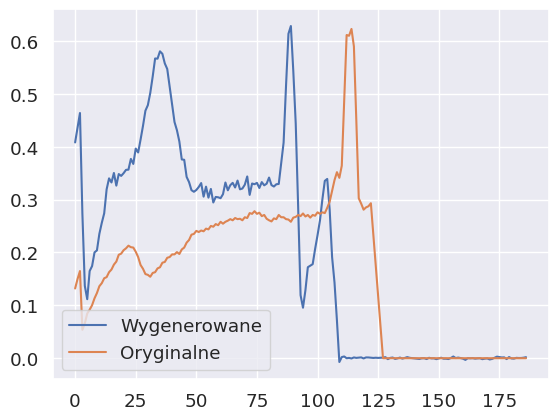

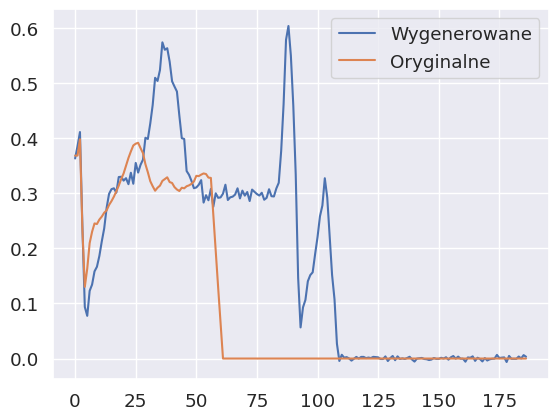

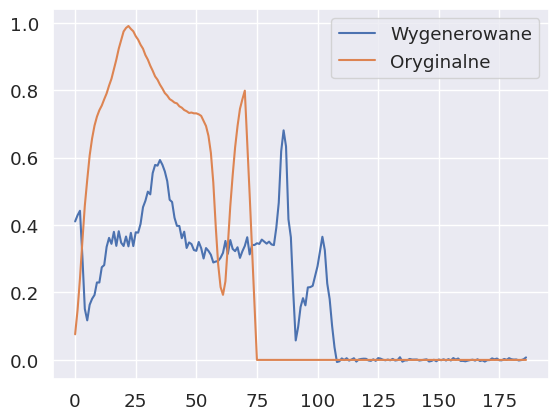

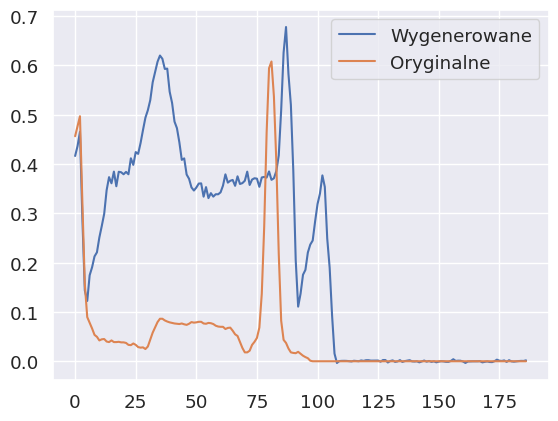

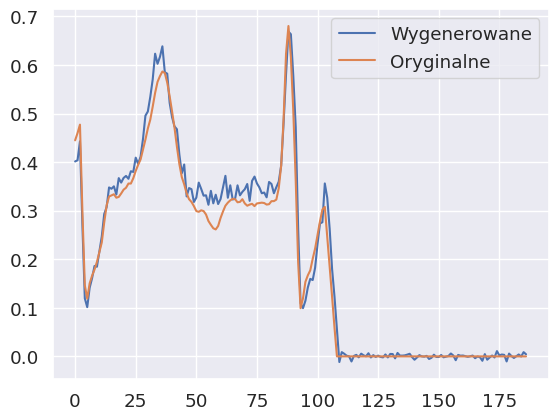

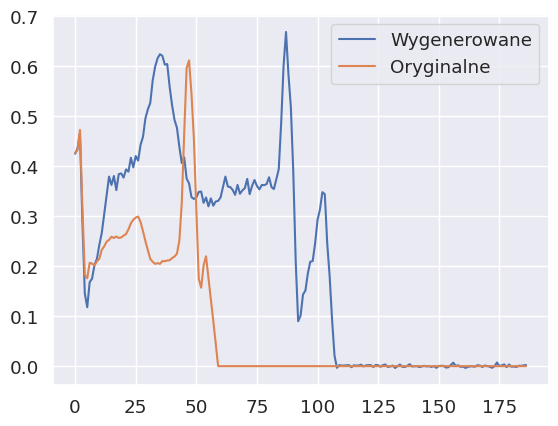

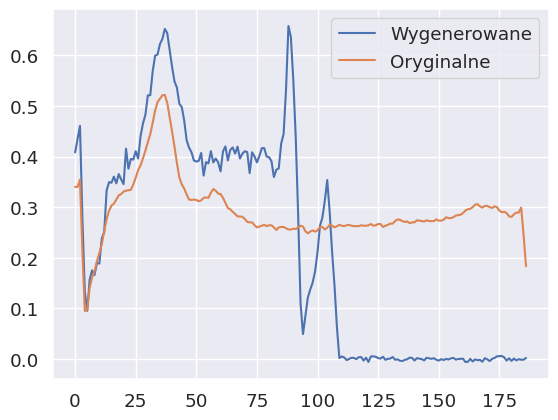

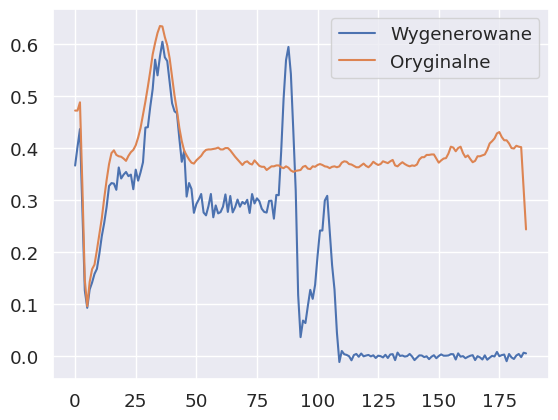

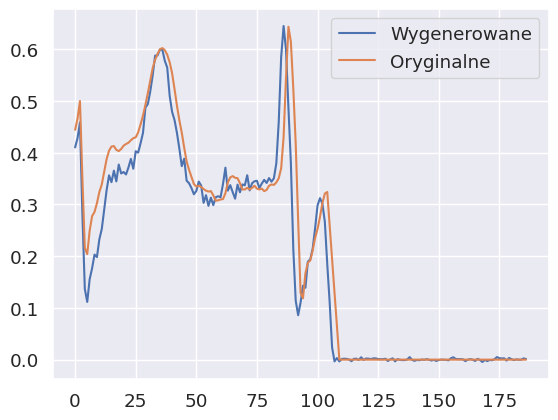

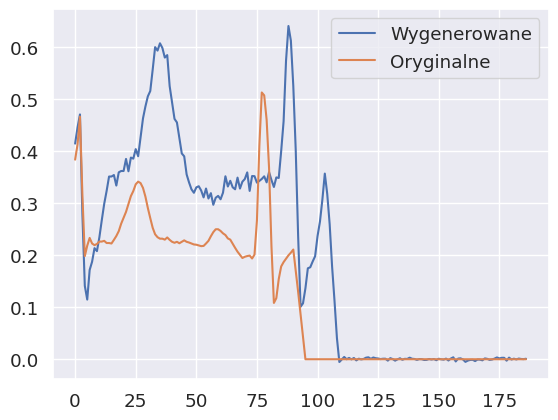

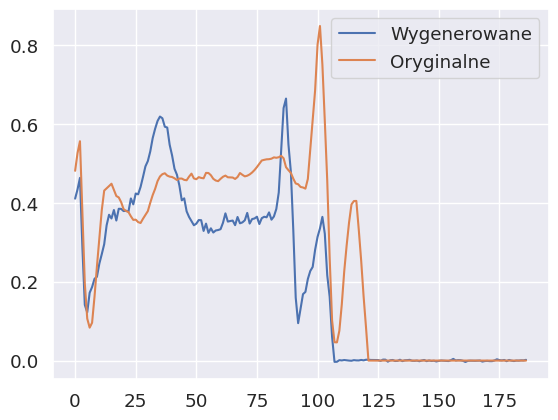

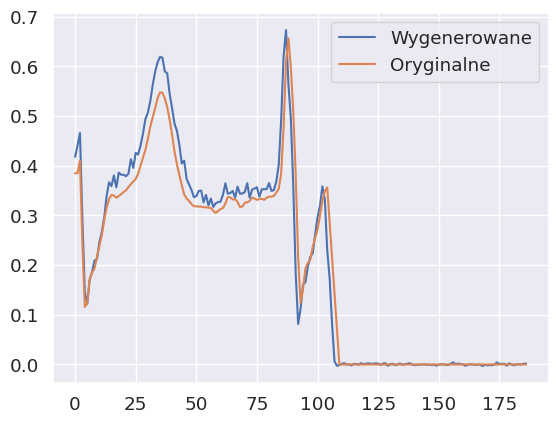

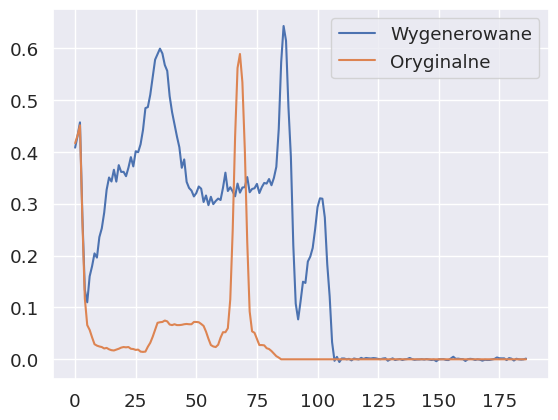

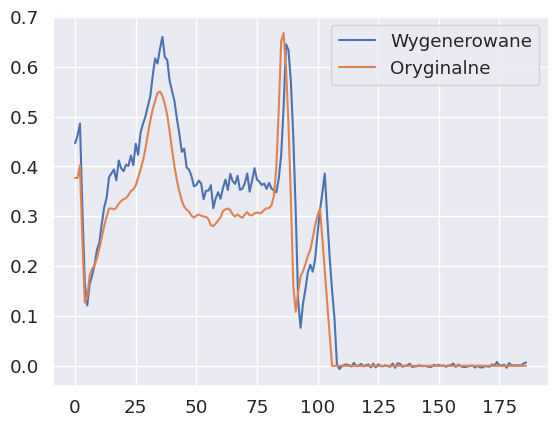

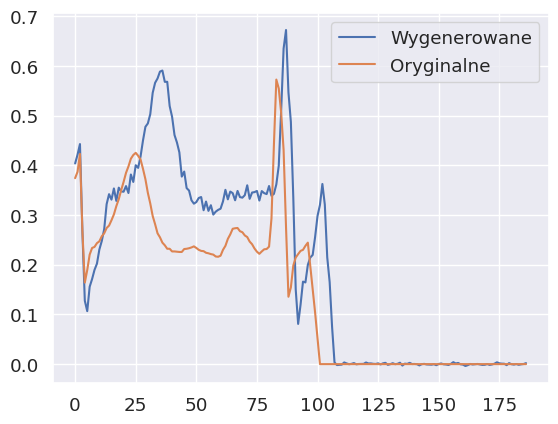

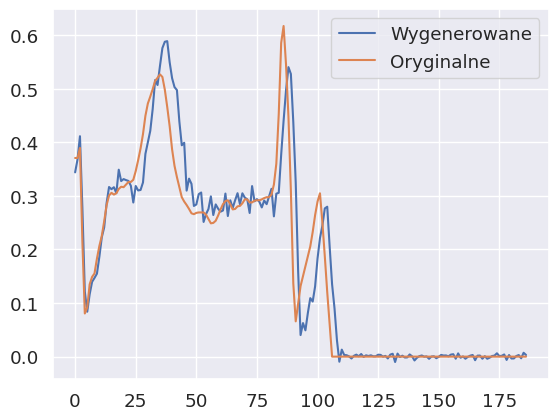

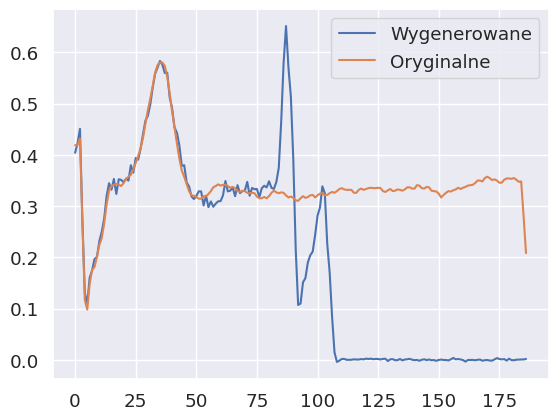

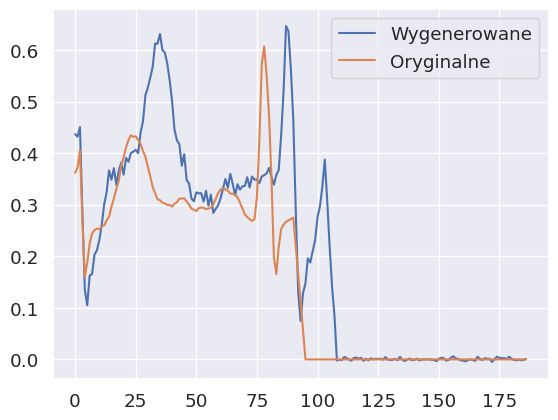

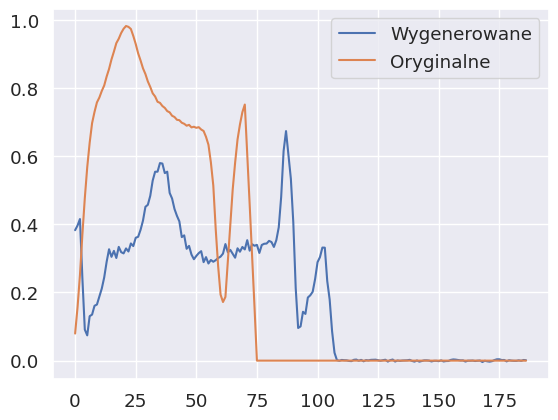

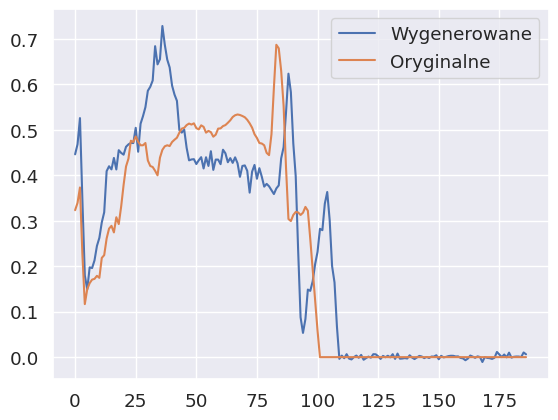

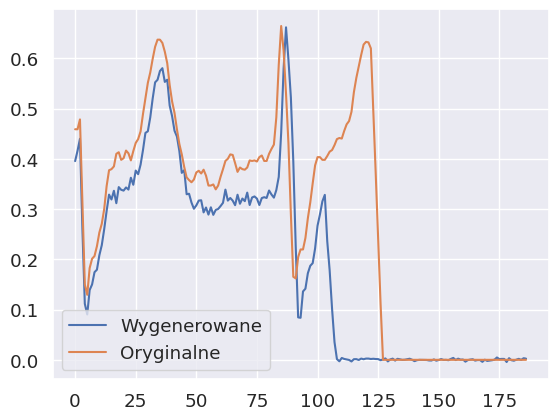

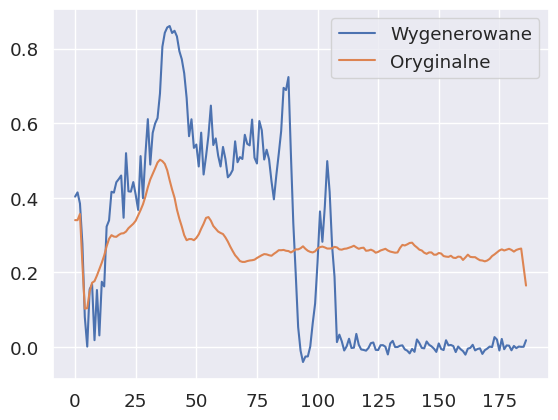

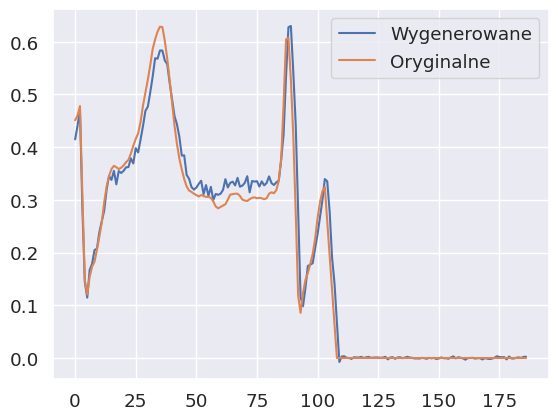

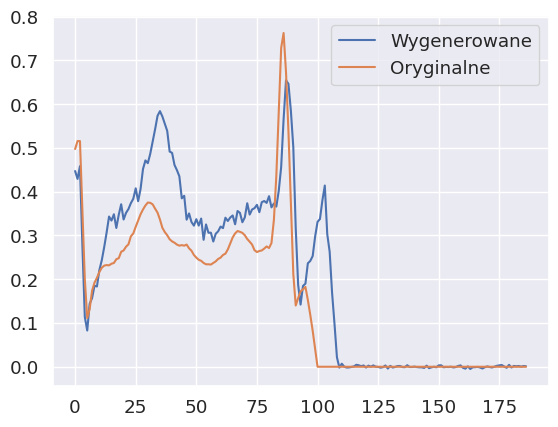

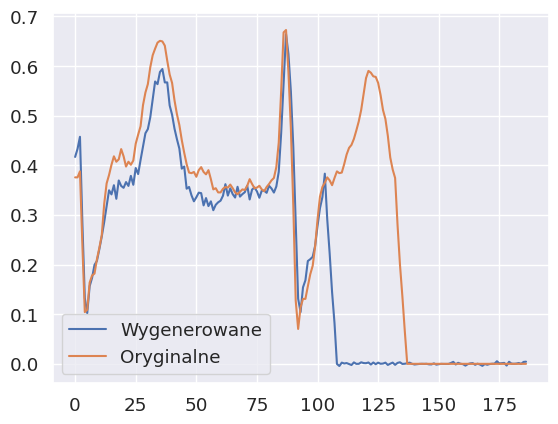

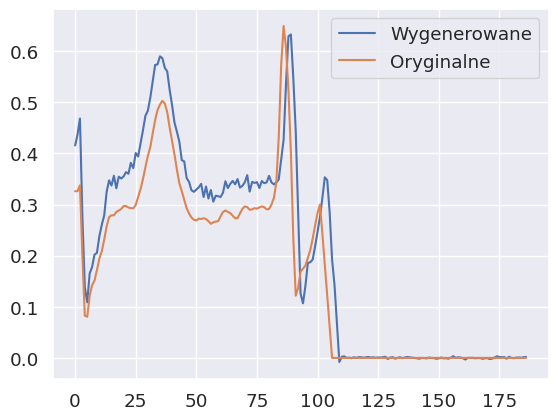

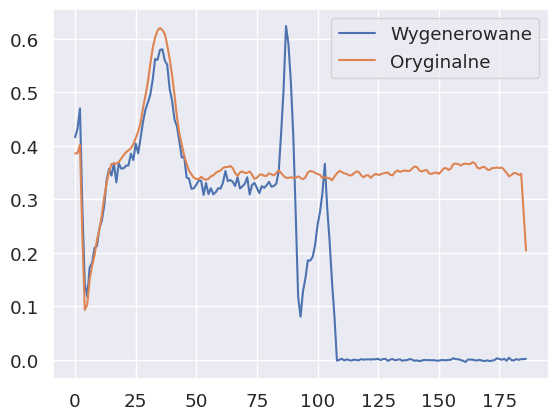

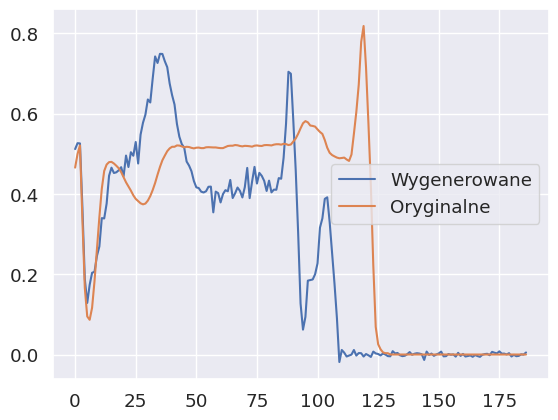

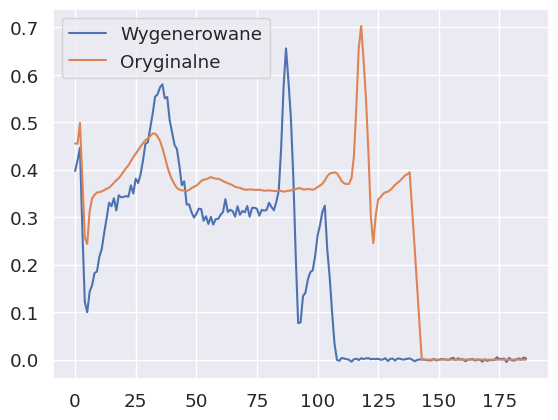

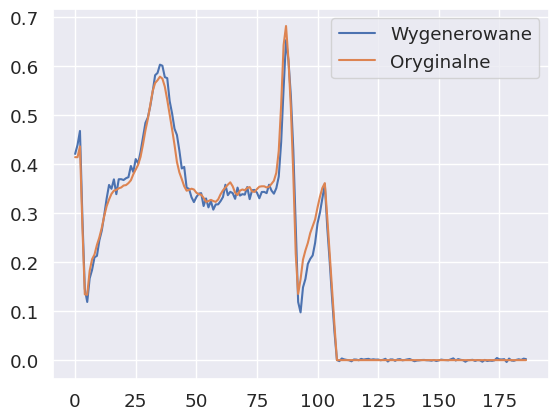

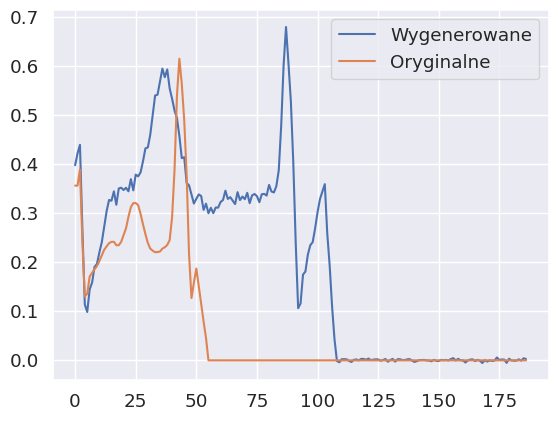

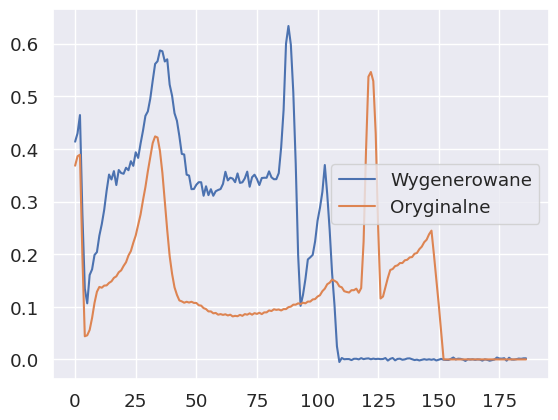

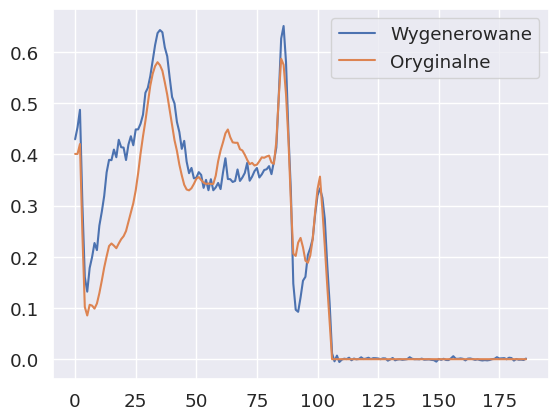

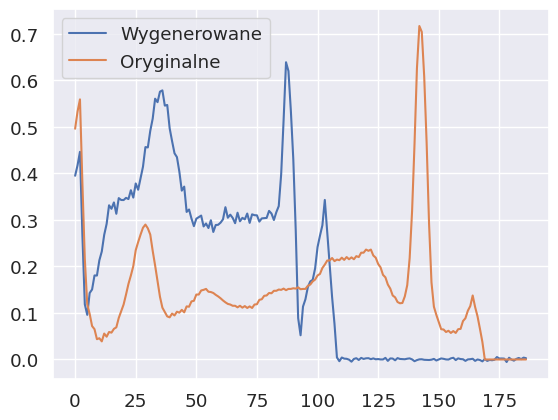

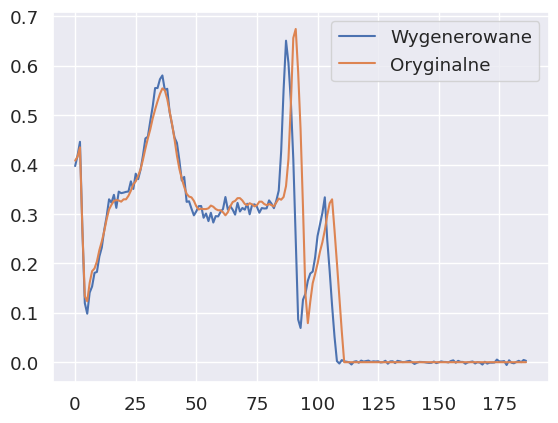

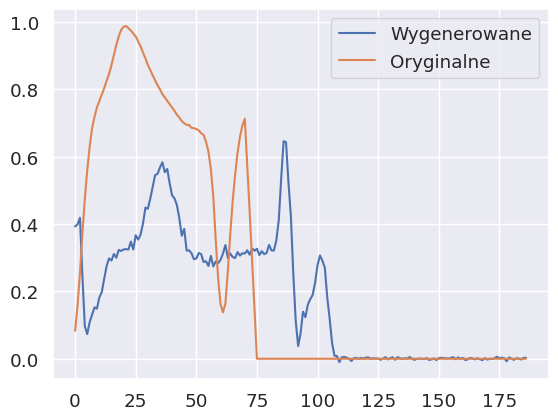

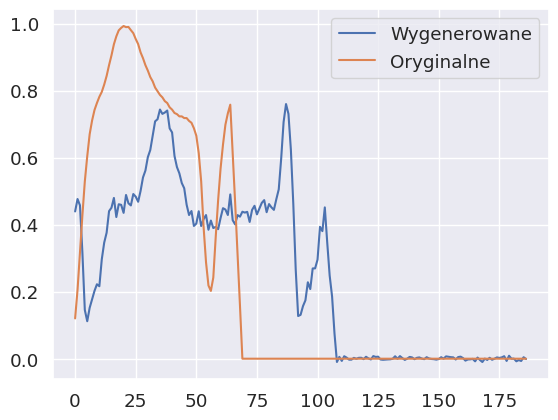

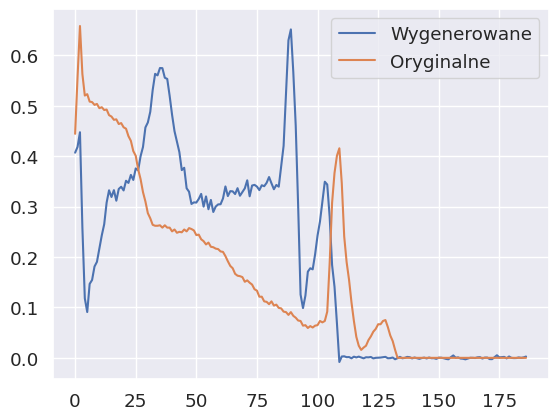

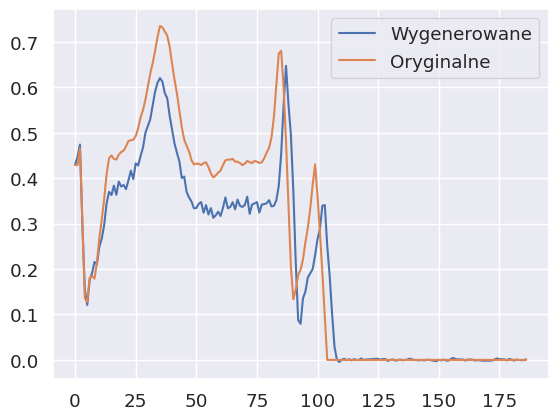

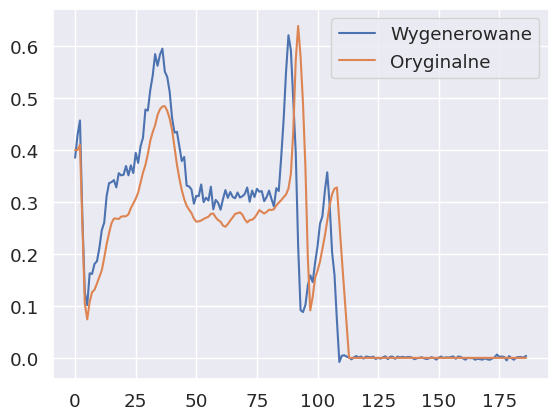

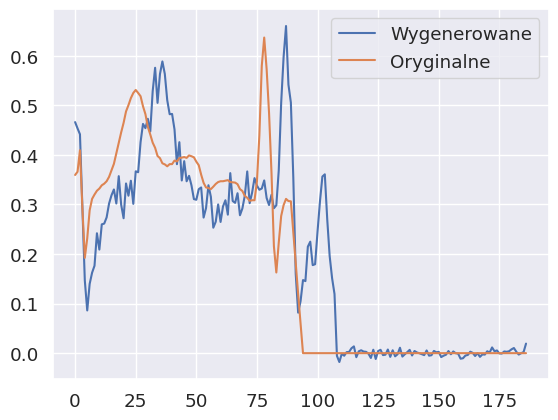

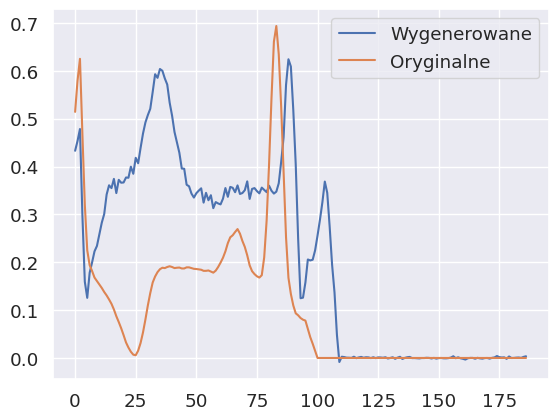

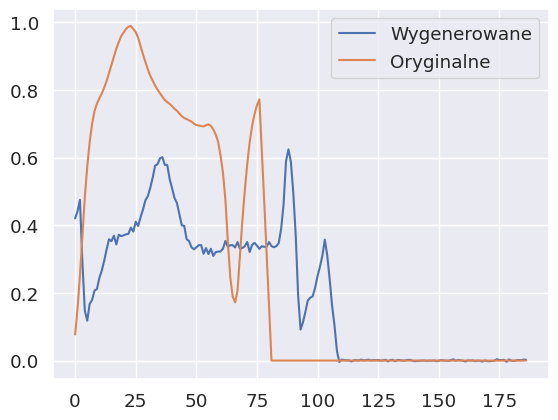

KeyboardInterrupt: ignored

In [41]:
for i in range(len(twos)):
    plt.figure()
    plt.plot(twos[i], label='Wygenerowane')
    plt.plot(two[i], label='Oryginalne')

    # Dodanie legendy do wykresu
    plt.legend()

    # Wyświetlenie wykresu
    plt.show()

In [ ]:
from google.colab import files
twos=do_data(2777)
np.savetxt('twosleakyrelu.csv', twos, delimiter=',')

files.download('twosleakyrelu.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
loaded_array = np.loadtxt('twosleakyrelu.csv', delimiter=',')

In [ ]:
for i in range(10):
    plt.figure()
    plt.plot(loaded_array[i], label='Wygenerowane')
    plt.plot(two[i], label='Oryginalne')

    # Dodanie legendy do wykresu
    plt.legend()

    # Wyświetlenie wykresu
    plt.show()

NameError: ignored

<Figure size 640x480 with 0 Axes>

In [10]:
twotest = []


for i in range(len(Y_test)):
    if np.array_equal(Y_test[i], [0.0, 1.0, 0.0, 0.0, 0.0]):
        twotest.append(X_test[i])


twotest=np.array(twotest)


In [40]:
generated=do_data(len(twotest))

In [41]:
generated=np.squeeze(generated)
twotest=np.squeeze(twotest)

In [42]:
validation=np.concatenate([generated, moving_average_filter(twotest)], axis=0)

In [43]:
discriminator_predictions = discriminator.predict(validation)

35/35 [==============================] - 0s 2ms/step


In [44]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Assuming generated and twotest are your generated and real data
true_labels = [0] * generated.shape[0] + [1] * twotest.shape[0]
predicted_labels = (discriminator_predictions > 0.5).astype(int).flatten()

accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)
confusion = confusion_matrix(true_labels, predicted_labels)

print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")
print("Confusion Matrix:")
print(confusion)


Accuracy: 0.9181654676258992, Precision: 0.9329608938547486, Recall: 0.9010791366906474, F1 Score: 0.9167429094236048
Confusion Matrix:
[[520  36]
 [ 55 501]]


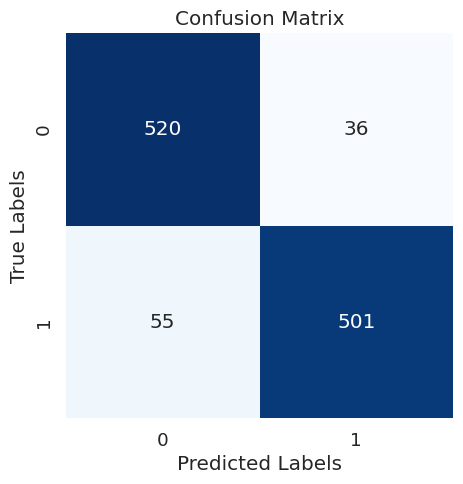

In [45]:
plt.figure(figsize=(5, 5))
sns.set(font_scale=1.2)
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False)



plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.show()